In [1]:
import numpy as np
import fenics as fe
fe.set_log_level(40)

from tqdm.notebook import tqdm_notebook

In [2]:
## Define heat conductivity $\lambda (\alpha)$ [W/(m K)]
def lambda_concrete(vf_aggr, vf_paste, alpha):
    """
    heat conductivity of concrete via multiscale homogenization [W/(m K)]
    """
    lambda_aggr= 3.0 # https://doi.org/10.1016/j.jrmge.2021.08.008 from graph for sand at zero porosity
    lambda_paste= 1.0

    lambda_ini_concrete_lower= lambda_paste + vf_aggr / (1/(lambda_aggr-lambda_paste) + vf_paste/(3*lambda_paste))
    lambda_ini_concrete_upper= lambda_aggr + vf_paste / (1/(lambda_paste-lambda_aggr) + vf_aggr/(3*lambda_aggr))
    lambda_ini_concrete_mean= (lambda_ini_concrete_lower+lambda_ini_concrete_upper)/2.

    lambda_concrete_sealed= lambda_ini_concrete_mean*(1+0.22*alpha)
    return lambda_concrete_sealed


## Define specific heat capacity $c(\alpha)$ [J/(kg K)]
def c_concrete(wcr, mf_aggr, mf_paste, alpha):
    """
    Specific heat capacity of concrete via multiscale homogenization [J/(kg K)]
    """
    c_water= 4180 # [J/(kg K)]
    c_cement= 750
    c_aggr= 800 # 10.13140/RG.2.1.1045.0403

    c_paste= (c_water*wcr+c_cement)/(1+wcr)*(1-0.26*(1-fe.exp(-2.9*alpha))) # assuming sealed conditions
    c_concrete= mf_aggr*c_aggr + mf_paste*c_paste
    return c_concrete


## Define affinity-based hydration model [1/s]
def evalChemAffinity(alpha):
    """
    Evaluate chemical affinity-based hydration model.
    Model parameters must be calibrated using isothermal calorimetry for each cement paste individually prior usage.
    """
    ## Calibration parameters of affinity-based hydration model for CEM I 42.5 R Hranice, wcr=0.45
    B1= 0.000134071
    B2= 0.00689365
    eta= 5.72794
    alpha_infty= 0.85

    if alpha==0:
        Atld_ref=0
    else:
        Atld_ref= B1*(B2/alpha_infty+alpha)*(alpha_infty-alpha)*fe.exp(-eta*alpha/alpha_infty)

    return Atld_ref


## Define scaling parameter $\beta_T$ for temperature [$-$]
def betaT(T):
    """
    Evaluate scaling parameter from temperature fluctuation
    """
    Ea= 38300 # [J/mol], apparent activation energy
    R= 8.31441 # [J/(mol*K)], universal gas constant
    Tref= 293.15 # [K] = 20 C, reference temperature for which Atld_ref is measured

    betaT= fe.exp(Ea/R*(1/Tref-1/(T+273.15)))

    return betaT


## Define scaling parameter $\beta_H$ for humidity [$-$]
def betaH(H):
    """
    Evaluate scaling parameter from humidity fluctuation
    """
    a= 7.5 # [-] from [Bazant1972]
    betaH= 1./(1.+(a-a*H)**4.)
    return betaH


## Alternate diffusion coefficient $D_H$ [m^2/s] from [Bazant:1972]
def diffusivityBazant(H):
    """
    evaluates the diffusivity from [Bazant:1972]

    Parameters
    ----------
    H : float
        relative humidity [-].

    Returns
    -------
    DH
    """
#     ## fib MC 2010 recomendation (also in [Oliveira:2015]):
#     fcm= 30 # [MPa]; estimated compressive strength of concrete
#     DH1= (1e-8)/(fcm-8) # = 4.5454e-10 m^2/s for fc=30; =39.3 mm^2/day
#     gamma= 0.05; Hc= 0.75; n= 12

    ##[Havlasek:2016]:
    #DH1= 2.8935e-10 # [m^2/s]; =25 mm^2/day => 25/8.64e+10 
    #gamma= 0.1; Hc= 0.8; n= 10 

    ##[Sovjak:2018]:
    #DH1= 4.6296e-10 # [m^2/s]; =40 mm^2/day => 40/8.64e+10
    #gamma= 0.05; Hc=0.75; n= 12
    
    ## my custom:
    DH1= 200/8.64e+10 # [m^2/s]
    gamma= 0.05 # 0.05 
    Hc=0.75 # 0.75 
    n= 12 # 12

    return DH1 * (gamma + (1-gamma)/(1+( (1-H)/(1-Hc) )**n))


## Hygrothermic coefficient [1/K] from [Bazant:1972]
def heat_rate(T_new, T_old, dt):
    return (T_new-T_old)/dt

def HTcoef(H_new):
    return 0.0135*H_new*(1-H_new)/(1.25-H_new)

In [3]:
width= 1.0
height= 1.0
thick= 1.0 # [m]; out-of-plane dimension, default= 1 m for extruded structures


## Mix design - mass of constituent to create a 1 m^3 of concrete
m_cement= 310 # [kg/m^3]
m_water= 0.4*m_cement # [kg/m^3]
m_fineAggr= 1318 # [kg/m^3]
m_coarseAggr= 440 # [kg/m^3]

rho_cement= 3140 # [kg/m^3] (estimated)
rho_water= 1000 # [kg/m^3] (estimated)
rho_aggr= 2600 # [kg/m^3] (estimated)


## Thermal characteristic of cement used
Qpotential= 520000 # potential heat of hydration in [J/kg]; =530 J/g for goldenDefault

## Initial & environmental conditions
Tini= 21
# heatFlowSides= 3.5
# heatFlowBtm= 50 # [W/(m^2 K)] coefficient of heat transfer

T_remote= fe.Expression('newt', newt=16, degree=2)
variableTemperature= 1

if variableTemperature:
    temperature_file_path = 'DataExperiment_Smilauer2009_temperature.txt'
    def loadTemperatureFromFile(temperature_file_path, given_time):
        data = np.loadtxt(temperature_file_path)
        time = data[:, 0]*24*60*60
        temperature = data[:, 1]
        interpolated_temperature = np.interp(given_time, time, temperature)
        return interpolated_temperature


Hini= 1.0 # [-]; initial RH throughout the cross-section
# humFlowSides= 3e-9
# humFlowBtm= 3e-9 # [m/s] coefficient of hygric exchange between surface and environment

H_remote= fe.Expression('newh', newh=0.6, degree=2)

## Time evaluation
total_time= 5*24*60*60 # [s]; target time
# dt= 30*60
dt= 10*60

In [4]:
## Mesh discretization
numElemW= 100 #70
numElemH= numElemW * height/width

mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(width, height), nx=int(numElemW), ny=int(numElemH), diagonal="right")

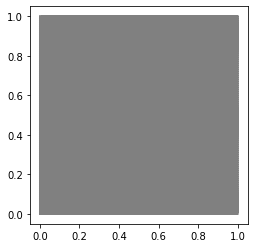

In [5]:
fe.plot(mesh)

In [6]:
quadrature_rules={'quadrature_degree' : 1, 'quadrature_scheme' : 'default'}

In [7]:
element_family = 'CG'

element = fe.FiniteElement(element_family, mesh.ufl_cell(),
                               degree=quadrature_rules.get('quadrature_degree'),
                               quad_scheme=quadrature_rules.get('quadrature_scheme'))
mixed_element = fe.MixedElement([element,]*3)

W = fe.FunctionSpace(mesh, mixed_element)

u_ = fe.TestFunctions(W)

δu = fe.TrialFunction(W)

u_new = fe.Function(W)

u_old = fe.Function(W)

dx = fe.dx(metadata={'quadrature_degree': quadrature_rules['quadrature_degree']})

In [8]:
## Calculate mix proportions
rho_concrete= m_cement+m_water+m_fineAggr+m_coarseAggr # density of 1 m^3 of concrete

# Mix-related proportions of constituents: mf_* mass fraction; vf_* volume fraction
wcr= m_water/m_cement # water-to-cement mass ratio
mf_paste= (m_cement+m_water)/(m_cement+m_water+m_fineAggr+m_coarseAggr)
mf_aggr= (m_fineAggr+m_coarseAggr)/(m_cement+m_water+m_fineAggr+m_coarseAggr)

vf_paste= (m_cement/rho_cement+m_water/rho_water)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)
vf_aggr= (m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)


# Calculate dimension of the mesh
dim= mesh.topology().dim()

# Define boundary on mesh
surface_dim= dim - 1
boundaries= fe.MeshFunction("size_t", mesh, surface_dim)

# setting tags for all boundaries as 99
boundaries.set_all(99)

## Define INITIAL CONDITION
element_space = fe.FunctionSpace(mesh, element)

s = fe.Function(element_space)

s.interpolate(fe.Constant(Tini))
fe.assign(u_old.sub(0), s)

s.interpolate(fe.Constant(Hini)) # discretize the IC onto the function space - translate to the nodal values on function space on this mesh
fe.assign(u_old.sub(1), s)

## Boundary conditions
"""
mark BC ID as follows:

#3#
0 1
#2#

""" 
#### MARK BOUNDARIES:
left= fe.CompiledSubDomain("near(x[0], 0) && on_boundary")
left.mark(boundaries, 0)
# bc_left= fe.DirichletBC(W, fe.Constant((20.0)), left)

# right= fe.CompiledSubDomain("near(x[0], 0.10) && on_boundary")
right= fe.CompiledSubDomain("near(x[0], %.3f) && on_boundary" %(width))
right.mark(boundaries, 1)

bottom = fe.CompiledSubDomain("near(0, x[1]) && on_boundary")
bottom.mark(boundaries, 2)

# top= fe.CompiledSubDomain("near(0.50, x[1]) && on_boundary")
top= fe.CompiledSubDomain("near(%.3f, x[1]) && on_boundary" %(height))
top.mark(boundaries, 3)


#### ASSIGN BC FOR TEMPERATURE:
hT= [2., 2., 50., 9.] 
boundary_conditions_T= {0: {'Robin':     (hT[0], T_remote)}, #0: {'Dirichlet': fe.Constant(20.0)}
                        1: {'Robin':     (hT[1], T_remote)},
                        2: {'Robin':     (hT[2], T_remote)},
                        3: {'Robin':     (hT[3], T_remote)} }

#### Collect DIRICHLET BC:
bcs = []
for i in boundary_conditions_T:
    if 'Dirichlet' in boundary_conditions_T[i]:
        bcT= fe.DirichletBC(W.sub(0), boundary_conditions_T[i]['Dirichlet'], boundaries, i)
        bcs.append(bcT)

#### Collect ROBIN BC:
ds = fe.Measure('ds', domain=mesh, subdomain_data=boundaries)   
integrals_R_a_T = []
integrals_R_L_T = []
for i in boundary_conditions_T:
    if 'Robin' in boundary_conditions_T[i]:
        r, s = boundary_conditions_T[i]['Robin']
        integrals_R_a_T.append(r*u_new[0]*u_[0]*ds(i))
        integrals_R_L_T.append(r*s*u_[0]*ds(i))


#### ASSIGN BC FOR HUMIDITY :
hW= [3.47e-9, 3.47e-9, 1.15741e-9, 3.47e-9] 
boundary_conditions_H = {0: {'Robin':     (hW[0], H_remote)}, #0: {'Dirichlet': fe.Constant(0.98)}
                     1: {'Robin':     (hW[1], H_remote)},
                     2: {'Robin':     (hW[2], H_remote)},
                     3: {'Robin':     (hW[3], H_remote)} }

#### Collect DIRICHLET BC:

for i in boundary_conditions_H:
    if 'Dirichlet' in boundary_conditions_H[i]:
        bcH= fe.DirichletBC(W.sub(1), boundary_conditions_H[i]['Dirichlet'], boundaries, i)
        bcs.append(bcH)


#### Collect ROBIN BC:
integrals_R_a_H = []
integrals_R_L_H = []
for i in boundary_conditions_H:
    if 'Robin' in boundary_conditions_H[i]:
        r1, s1 = boundary_conditions_H[i]['Robin']
        integrals_R_a_H.append(r1*u_new[1]*u_[1]*ds(i))
        integrals_R_L_H.append(r1*s1*u_[1]*ds(i))


## Solution parameters
num_steps= int((total_time / dt) + 1) # number of time steps +1 at end to reach exact time

snes_solver_parameters = {"nonlinear_solver": "newton",
                      "newton_solver": {"linear_solver": "gmres",
                                        "preconditioner" :'ilu',
                                        "maximum_iterations": 100000,
                                        "report": False,
                                        "absolute_tolerance":1e-10,
                                        "relative_tolerance":1e-10,
                                        "error_on_nonconvergence": True}}


## Solve coupled problem
## Starting values
t= fe.Constant(0) # [sec] keep track of elapsed time, should be equal throughout cross-section

alpha= fe.Constant(0) # [-]
dalpha= 1e-7 # constant increment of alpha for numerical integration of time

max_T= Tini
min_H= Hini

Qtot= Qpotential*m_cement*thick # total stored heat in assumed sample 


def Qdot(alpha, T, H):
    return Qtot * evalChemAffinity(alpha) * betaT(T) * betaH(H)

def dwhdt(alpha, T, H):
    return 0.23*m_cement*width*height*thick*evalChemAffinity(alpha) * betaT(T) * betaH(H) # evaluate water consumed by hydration

def DH(H):
    return diffusivityBazant(H)


# weak form for temperature
var = rho_concrete*c_concrete(wcr, mf_aggr, mf_paste, u_new[2])*u_new[0]*u_[0]*dx \
    + dt*lambda_concrete(vf_aggr, vf_paste, u_new[2])*fe.dot(fe.grad(u_new[0]), fe.grad(u_[0]))*dx \
    + dt*sum(integrals_R_a_T) \
    - rho_concrete*c_concrete(wcr, mf_aggr, mf_paste, u_new[2])*u_old[0]*u_[0]*dx \
    - dt*Qdot(u_new[2], u_new[0], u_new[1])*u_[0]*dx \
    - dt*sum(integrals_R_L_T)

k= fe.Constant(320)

# weak form for humidity
var += u_new[1]*u_[1]*dx \
    + dt*DH(u_new[1])*fe.dot(fe.grad(u_new[1]), fe.grad(u_[1]))*dx \
    + dt*sum(integrals_R_a_H) \
    + (dt/k)*dwhdt(u_new[2], u_new[0], u_new[1])*u_[1]*dx \
    - dt*HTcoef(u_new[1])*heat_rate(u_new[0], u_old[0], dt)*u_[1]*dx \
    - u_old[1]*u_[1]*dx \
    - dt*sum(integrals_R_L_H)

# weak form for affinity
var += u_new[2]*u_[2]*dx \
    - u_old[2]*u_[2]*dx \
    - dt*evalChemAffinity(u_new[2]) * betaT(u_new[0]) * betaH(u_new[1]) *u_[2]*dx \
    

# solve variational problem
problem = fe.NonlinearVariationalProblem(var, u_new, bcs, fe.derivative(var, u_new, δu))

solver= fe.NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
save_dataTXT= 1
if save_dataTXT:
    expTXTfile= "MMdata_v8_validation_Smilauer2009_temperature_1m3cube_variableT.txt"
    fout= open(expTXTfile, 'w')

######################################################################################################
## SOLVE PROBLEM
splitted_u_old = u_old.split(True)

In [10]:
for s in tqdm_notebook(range(0, num_steps)):
    
    if variableTemperature:
        T_remote.newt= loadTemperatureFromFile(temperature_file_path, given_time= s*dt)
    
    solver.solve()
    u_old.assign(u_new)
    splitted_u_old = u_old.split(True)
        
        
    print('%.2f\t%.4f\t%.3f\t%.3f' %(s*dt/60./60.,
                                     splitted_u_old[2](width/2., height/2.),
                                     splitted_u_old[0](width/2., height/2.),
                                     splitted_u_old[0](width-0.03, height/2.)))
    if save_dataTXT:
        fout.write('%.3f\t%.4f\t%.3f\t%.3f\t%.4f\t%.3f\t%.3f\t%.4f\t%.3f\t%.3f\t%.4f\t%.3f\t%.3f\n' 
                   %(s*dt/60./60.,
                     splitted_u_old[0](width/2., height/2.),
                     splitted_u_old[1](width/2., height/2.),
                     splitted_u_old[2](width/2., height/2.),
                     splitted_u_old[0](width-0.03, height/2.),
                     splitted_u_old[1](width-0.03, height/2.),
                     splitted_u_old[2](width-0.03, height/2.),
                     splitted_u_old[0](0., height),
                     splitted_u_old[1](0., height),
                     splitted_u_old[2](0., height),
                     splitted_u_old[0](0., 0.),
                     splitted_u_old[1](0., 0.),
                     splitted_u_old[2](0., 0.)))
#     T_old.rename("Temperature", "Time")
#     vtkfile << (T_old, t/3600)
#     H_old.rename("RH", "Time")
#     vtkfile << (H_old, t/3600)

    

0.00	0.0006	21.047	21.012
0.17	0.0013	21.097	21.024
0.33	0.0020	21.152	21.043
0.50	0.0028	21.210	21.070
0.67	0.0036	21.272	21.104
0.83	0.0045	21.340	21.144
1.00	0.0055	21.411	21.191
1.17	0.0065	21.488	21.244
1.33	0.0076	21.571	21.305
1.50	0.0088	21.659	21.372
1.67	0.0101	21.753	21.445
1.83	0.0114	21.854	21.526
2.00	0.0129	21.961	21.613
2.17	0.0144	22.075	21.707
2.33	0.0160	22.197	21.808
2.50	0.0178	22.326	21.917
2.67	0.0196	22.463	22.033
2.83	0.0216	22.609	22.157
3.00	0.0237	22.763	22.288
3.17	0.0259	22.926	22.428
3.33	0.0282	23.099	22.576
3.50	0.0307	23.281	22.733
3.67	0.0333	23.473	22.899
3.83	0.0361	23.676	23.075
4.00	0.0390	23.888	23.260
4.17	0.0420	24.112	23.455
4.33	0.0452	24.346	23.660
4.50	0.0486	24.591	23.875
4.67	0.0521	24.847	24.101
4.83	0.0557	25.114	24.337
5.00	0.0596	25.393	24.583
5.17	0.0636	25.682	24.841
5.33	0.0677	25.983	25.108
5.50	0.0720	26.294	25.385
5.67	0.0764	26.617	25.671
5.83	0.0810	26.949	25.968
6.00	0.0858	27.292	26.273
6.17	0.0906	27.644	26.587
6.33	0.0957	

51.00	0.6225	36.218	33.425
51.17	0.6227	36.121	33.345
51.33	0.6228	36.024	33.266
51.50	0.6230	35.928	33.188
51.67	0.6231	35.831	33.111
51.83	0.6233	35.736	33.034
52.00	0.6234	35.640	32.958
52.17	0.6235	35.545	32.882
52.33	0.6237	35.450	32.807
52.50	0.6238	35.356	32.732
52.67	0.6239	35.262	32.657
52.83	0.6241	35.169	32.583
53.00	0.6242	35.076	32.510
53.17	0.6243	34.984	32.437
53.33	0.6245	34.892	32.365
53.50	0.6246	34.801	32.294
53.67	0.6247	34.710	32.223
53.83	0.6248	34.620	32.152
54.00	0.6249	34.530	32.083
54.17	0.6251	34.441	32.013
54.33	0.6252	34.352	31.945
54.50	0.6253	34.264	31.877
54.67	0.6254	34.177	31.810
54.83	0.6255	34.090	31.743
55.00	0.6256	34.004	31.677
55.17	0.6257	33.919	31.611
55.33	0.6258	33.834	31.546
55.50	0.6259	33.750	31.481
55.67	0.6261	33.666	31.416
55.83	0.6262	33.584	31.352
56.00	0.6263	33.501	31.289
56.17	0.6264	33.420	31.226
56.33	0.6265	33.339	31.164
56.50	0.6266	33.259	31.103
56.67	0.6267	33.179	31.042
56.83	0.6268	33.100	30.982
57.00	0.6269	33.022	30.923
5

101.67	0.6374	20.576	20.077
101.83	0.6374	20.552	20.067
102.00	0.6374	20.529	20.057
102.17	0.6374	20.506	20.049
102.33	0.6375	20.484	20.041
102.50	0.6375	20.462	20.033
102.67	0.6375	20.441	20.026
102.83	0.6375	20.420	20.020
103.00	0.6375	20.400	20.013
103.17	0.6375	20.380	20.007
103.33	0.6376	20.361	20.002
103.50	0.6376	20.343	19.997
103.67	0.6376	20.325	19.992
103.83	0.6376	20.307	19.988
104.00	0.6376	20.290	19.984
104.17	0.6376	20.274	19.980
104.33	0.6377	20.258	19.976
104.50	0.6377	20.243	19.972
104.67	0.6377	20.228	19.968
104.83	0.6377	20.214	19.965
105.00	0.6377	20.201	19.961
105.17	0.6377	20.188	19.958
105.33	0.6378	20.175	19.954
105.50	0.6378	20.163	19.951
105.67	0.6378	20.152	19.948
105.83	0.6378	20.141	19.945
106.00	0.6378	20.130	19.943
106.17	0.6378	20.120	19.940
106.33	0.6378	20.111	19.938
106.50	0.6379	20.102	19.935
106.67	0.6379	20.094	19.932
106.83	0.6379	20.086	19.929
107.00	0.6379	20.078	19.926
107.17	0.6379	20.071	19.923
107.33	0.6379	20.065	19.919
107.50	0.6380	20.058

In [11]:
if save_dataTXT:
    fout.close()

In [12]:
import matplotlib.pyplot as plt

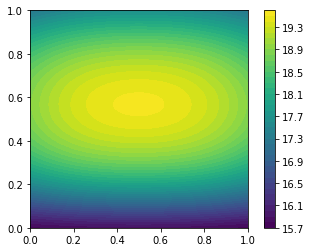

In [13]:
cb = fe.plot(splitted_u_old[0])
plt.colorbar(cb)

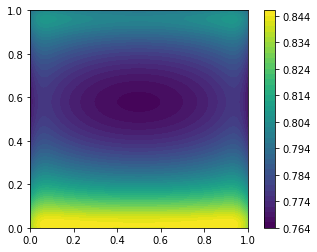

In [14]:
cb = fe.plot(splitted_u_old[1])
plt.colorbar(cb)

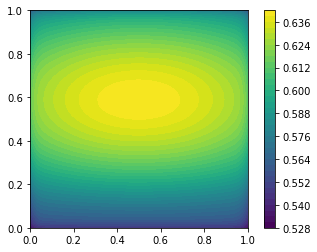

In [15]:
cb = fe.plot(splitted_u_old[2])
plt.colorbar(cb)